In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from gammapy.modeling.models.cube import IRFModel
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : uHTZmlm3 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 540251.66
  Predicted background counts     : 533641.14
  Predicted excess counts         : 6610.53

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 100300 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2462761.56

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal 

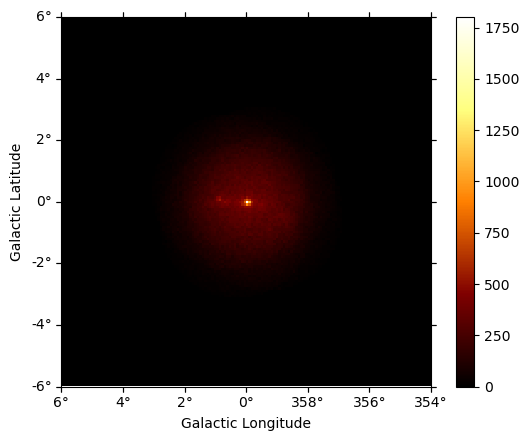

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models.remove('1745')
models.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
diff.parameters['tilt'].frozen = False
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.models[0].parameters['lon_0'].min = dataset_standard.models[0].parameters['lon_0'].value - 1
dataset_standard.models[0].parameters['lon_0'].max = dataset_standard.models[0].parameters['lon_0'].value + 1
dataset_standard.models[0].parameters['lat_0'].min = dataset_standard.models[0].parameters['lat_0'].value - 1
dataset_standard.models[0].parameters['lat_0'].max = dataset_standard.models[0].parameters['lat_0'].value + 1
dataset_standard.models[1].parameters['lon_0'].min = dataset_standard.models[1].parameters['lon_0'].value - 1
dataset_standard.models[1].parameters['lon_0'].max = dataset_standard.models[1].parameters['lon_0'].value + 1
dataset_standard.models[1].parameters['lat_0'].min = dataset_standard.models[1].parameters['lat_0'].value - 1
dataset_standard.models[1].parameters['lat_0'].max = dataset_standard.models[1].parameters['lat_0'].value + 1
#dataset_standard.models[0].parameters['lon_0'].frozen = True
#dataset_standard.models[0].parameters['lat_0'].frozen = True
#dataset_standard.models[1].parameters['lon_0'].frozen = True
#dataset_standard.models[1].parameters['lat_0'].frozen = True


dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


dataset_standard_N = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
models_N = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models_N.remove('1745')
models_N.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
diff.parameters['tilt'].frozen = False
models_N.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard_N.name)
bkg_model.parameters['tilt'].frozen  = False
models_N.append(bkg_model)
#irf model
IRFmodel = IRFModel(dataset_name = dataset_standard_N.name)
IRFmodel.parameters['bias'].frozen  = True
IRFmodel.parameters['resolution'].frozen  = True
IRFmodel.parameters['tilt_nuisance'].frozen  = False
models_N.append(IRFmodel)
dataset_standard_N.models = models_N
#dataset_standard_N.models.parameters['norm_nuisance'].value  = 0.0
#dataset_standard_N.models.parameters['tilt_nuisance'].value  = 0.0
#dataset_standard_N.exposure = dataset_standard_N.npred_exposure()
zero = 1e-24
shift = 0.1
tilt = 0.015
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix


dataset_standard_N.models[0].parameters['lon_0'].min = dataset_standard_N.models[0].parameters['lon_0'].value - 1
dataset_standard_N.models[0].parameters['lon_0'].max = dataset_standard_N.models[0].parameters['lon_0'].value + 1
dataset_standard_N.models[0].parameters['lat_0'].min = dataset_standard_N.models[0].parameters['lat_0'].value - 1
dataset_standard_N.models[0].parameters['lat_0'].max = dataset_standard_N.models[0].parameters['lat_0'].value + 1
dataset_standard_N.models[1].parameters['lon_0'].min = dataset_standard_N.models[1].parameters['lon_0'].value - 1
dataset_standard_N.models[1].parameters['lon_0'].max = dataset_standard_N.models[1].parameters['lon_0'].value + 1
dataset_standard_N.models[1].parameters['lat_0'].min = dataset_standard_N.models[1].parameters['lat_0'].value - 1
dataset_standard_N.models[1].parameters['lat_0'].max = dataset_standard_N.models[1].parameters['lat_0'].value + 1
#dataset_standard_N.models[0].parameters['lon_0'].frozen = True
#dataset_standard_N.models[0].parameters['lat_0'].frozen = True
#dataset_standard_N.models[1].parameters['lon_0'].frozen = True
#dataset_standard_N.models[1].parameters['lat_0'].frozen = True

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
print(dataset_standard_N)
#print(dataset_asimov)

In [4]:
estimator = TSMapEstimator(
    dataset_standard.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#dataset_standard.counts.geom.axes['energy'].edges[7:17]#energy_edges=[10, 500] * u.GeV#
)
maps = estimator.run(dataset_standard)

Text(0.5, 1.0, 'Iteration map')

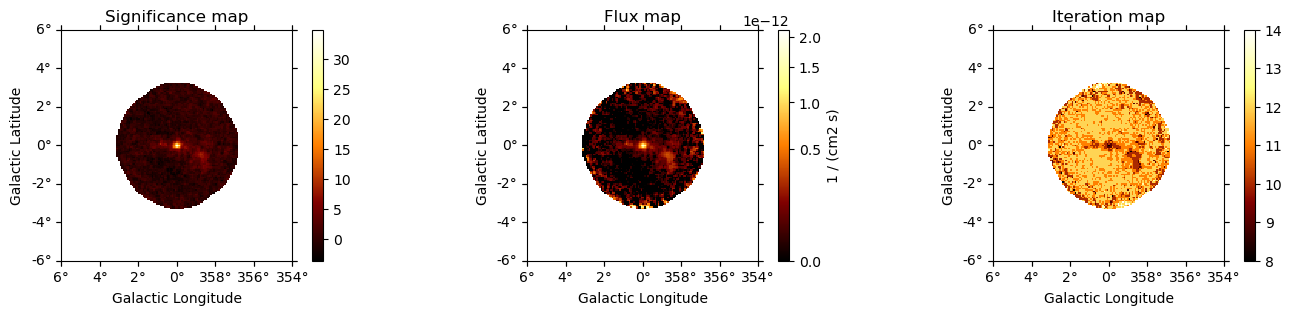

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax = ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
34.852,75,74,266.42019,-28.99116
8.8147,90,68,266.17092,-30.26529
8.5994,64,75,266.86284,-28.19759
6.8415,68,74,266.75217,-28.51273


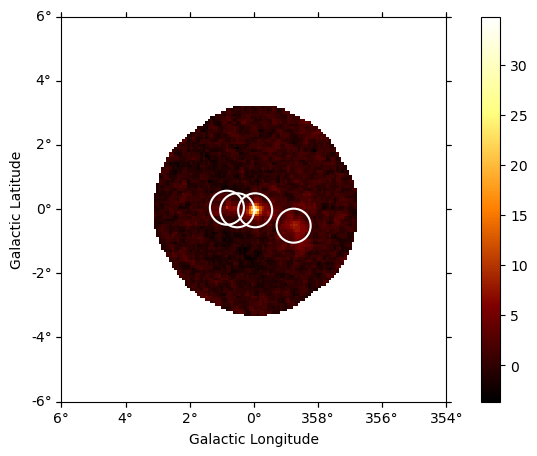

In [6]:
from gammapy.estimators.utils import find_peaks
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.25 deg")#threshold=5
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


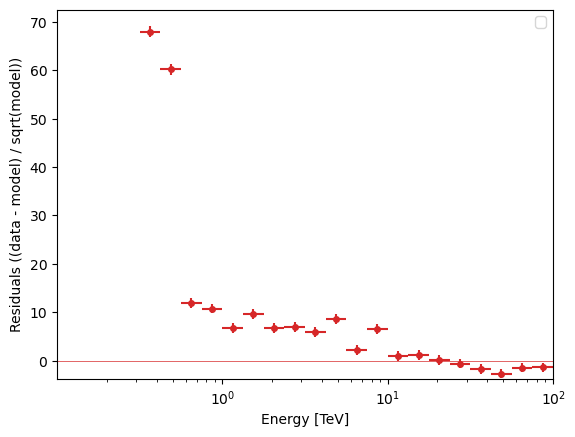

In [7]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

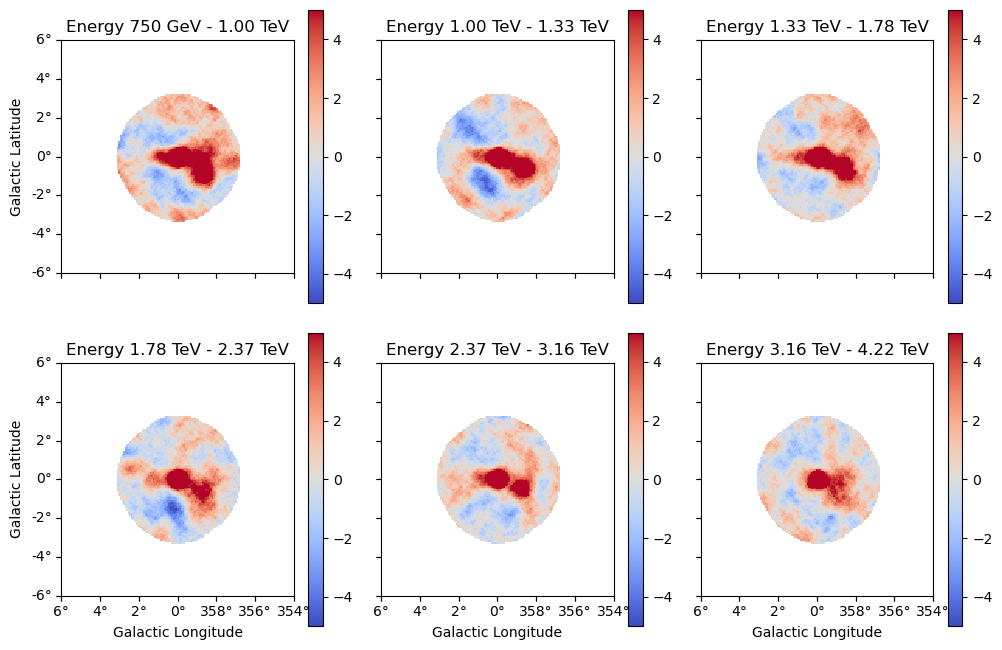

In [8]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.5 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[7:14])
result = estimator.run(dataset_standard)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

#### Setting up mask & fitting

In [9]:
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_standard_N.mask_fit = mask_space
#dataset_standard.mask_fit.plot_grid(vmin=0, vmax=1, add_cbar=True)

In [10]:
%%time
fit_standard = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_standard.backend = "minuit"
fit_standard.optimize_opts = minuit_opts
result_standard = fit_standard.run([dataset_standard])

CPU times: total: 47.5 s
Wall time: 48.6 s


In [11]:
print(dataset_standard)

MapDataset
----------

  Name                            : uHTZmlm3 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591507.16
  Predicted background counts     : 574454.15
  Predicted excess counts         : 17053.01

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303819.10

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

In [12]:
%%time
fit_standard_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_standard_N.backend = "minuit"
fit_standard_N.optimize_opts = minuit_opts
result_standard_N = fit_standard_N.run([dataset_standard_N])

CPU times: total: 6h 57min 20s
Wall time: 1h 58s


In [13]:
print(dataset_standard_N)
print("norm_nuisance:", dataset_standard_N.models[-1].parameters['norm_nuisance'].value, "pm", dataset_standard_N.models[-1].parameters['norm_nuisance'].error)
print("tilt_nuisance:", dataset_standard_N.models[-1].parameters['tilt_nuisance'].value, "pm", dataset_standard_N.models[-1].parameters['tilt_nuisance'].error)

MapDataset
----------

  Name                            : 4Gfu6dlQ 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591508.77
  Predicted background counts     : 574455.40
  Predicted excess counts         : 17053.37

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303819.35

  Number of models                : 5 
  Number of parameters            : 23
  Number of free parameters       : 15

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


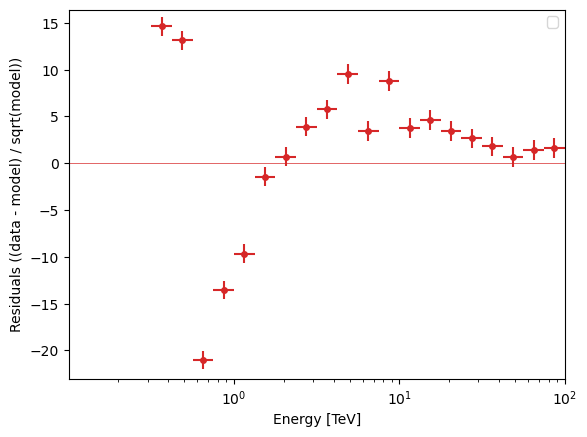

In [14]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\datasets\map.py:1108: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


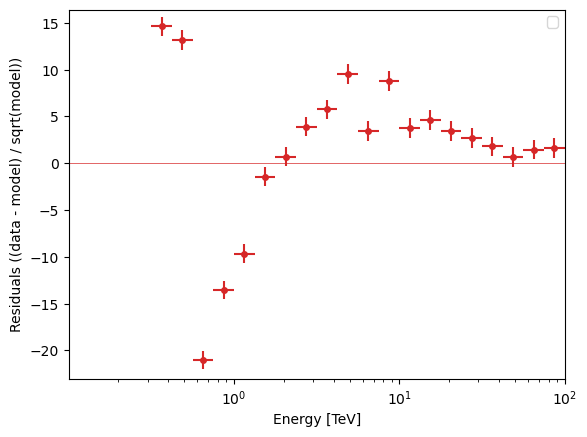

In [15]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

dataset_standard_N.plot_residuals_spectral(method = 'diff/sqrt(model)', ax =ax, color= "tab:red")
ax.legend()
#fig.savefig(f"plots/1b_Residual_standard.pdf")

In [16]:
print(dataset_standard.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.030   +/-    0.04             
    amplitude                     :   2.73e-12   +/- 8.3e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    359.943   +/-    0.00 deg         
    lat_0                         :     -0.049   +/-    0.00 deg         




In [17]:
print(dataset_standard_N.models[0])

SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.030   +/-    0.04             
    amplitude                     :   2.74e-12   +/- 5.1e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    359.943   +/-    0.00 deg         
    lat_0                         :     -0.049   +/-    0.00 deg         




In [18]:
for v in ['amplitude', 'index', 'lambda_']:
    for d in [dataset_standard, dataset_standard_N]:
        value = d.models['Source'].parameters[v].value
        error = d.models['Source'].parameters[v].error
        print(v,':', value, 'pm', error)

print('bkg norm: ', dataset_standard.background_model.parameters['norm'].value,' pm ', dataset_standard.background_model.parameters['norm'].error)
print('bkg norm: ', dataset_standard_N.background_model.parameters['norm'].value,' pm ', dataset_standard_N.background_model.parameters['norm'].error)

amplitude : 2.733011434009236e-12 pm 8.262906868322266e-14
amplitude : 2.7351285488707767e-12 pm 5.064065151626613e-13
index : 2.030101390516945 pm 0.039401465836845215
index : 2.030245065296281 pm 0.04098248049555129
lambda_ : 0.08874510187310557 pm 0.013347642968012784
lambda_ : 0.0888134983549071 pm 0.01307448361648773
bkg norm:  1.0571040747392333  pm  0.0016241935677204344
bkg norm:  1.0571048819427318  pm  0.0016165659303589454


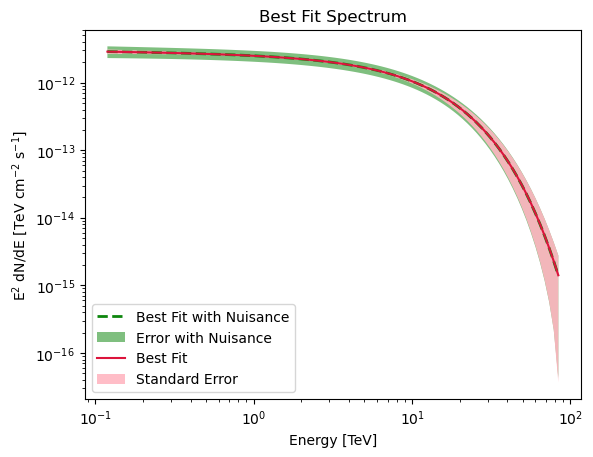

In [19]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
plt.legend()
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
fig = plt.gcf()
fig.savefig("plots/1b_spectra.pdf")

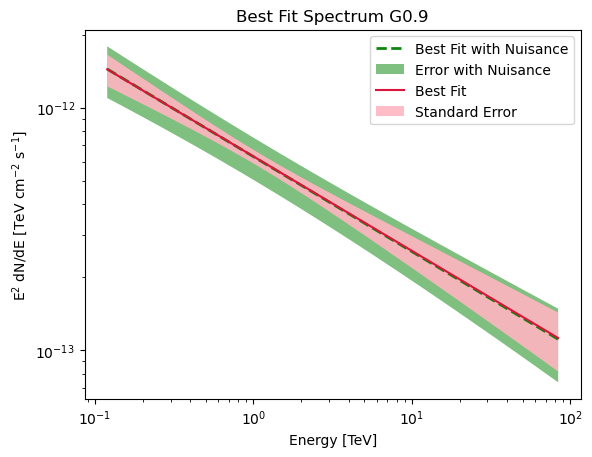

In [20]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

dataset_standard_N.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
plt.legend()
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum G0.9")
fig = plt.gcf()
fig.savefig("plots/1b_spectra_G09.pdf")

In [21]:
estimator = TSMapEstimator(
    dataset_standard.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#energy_edges=dataset_standard.counts.geom.axes['energy'].edges[10:14]
)
maps = estimator.run(dataset_standard)

Text(0.5, 1.0, 'Iteration map')

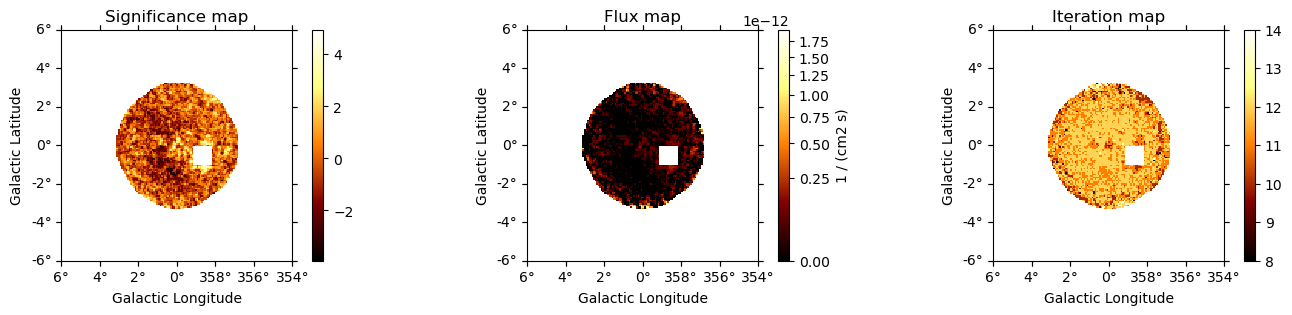

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
4.9438,73,73,266.59339,-28.89615


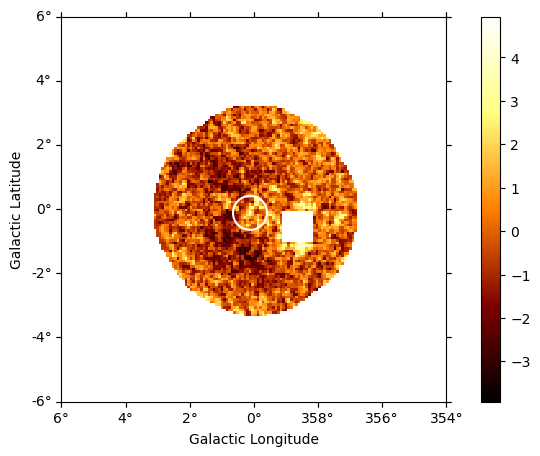

In [23]:
sources = find_peaks(maps["sqrt_ts"], threshold=4.9, min_distance="0.25 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

In [24]:
estimator_N = TSMapEstimator(
    dataset_standard_N.models[0],
    kernel_width="1 deg",
    energy_edges=[0.7, 3] * u.TeV#energy_edges=dataset_standard.counts.geom.axes['energy'].edges[10:14]
)
maps_N = estimator_N.run(dataset_standard_N)

Text(0.5, 1.0, 'Iteration map')

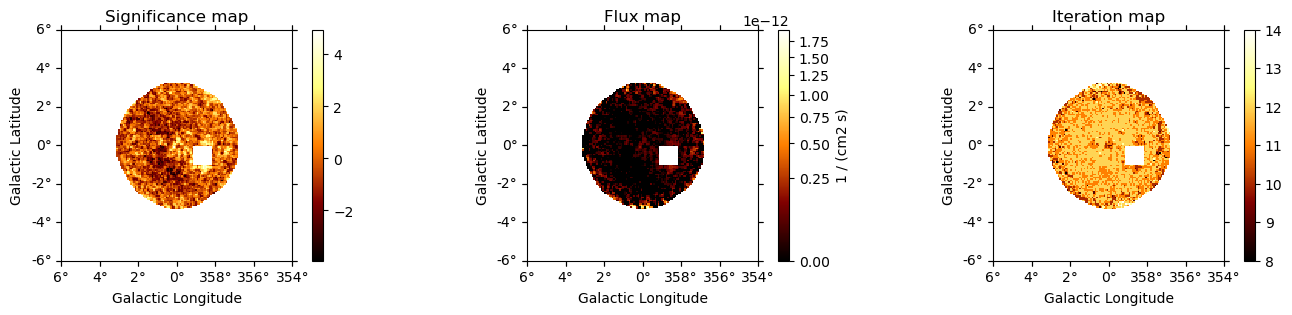

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(15, 3),
    subplot_kw={"projection": dataset_standard_N.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps_N["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps_N["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps_N["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")

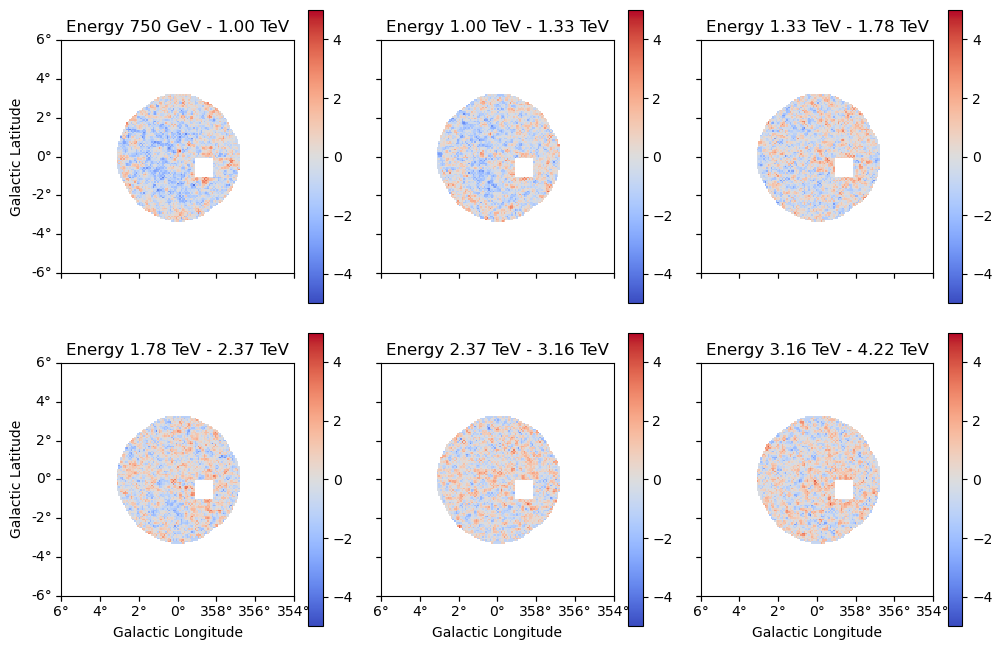

In [26]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.1 deg",
    energy_edges=dataset_standard.counts.geom.axes['energy'].edges[7:14])
result = estimator.run(dataset_standard)
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

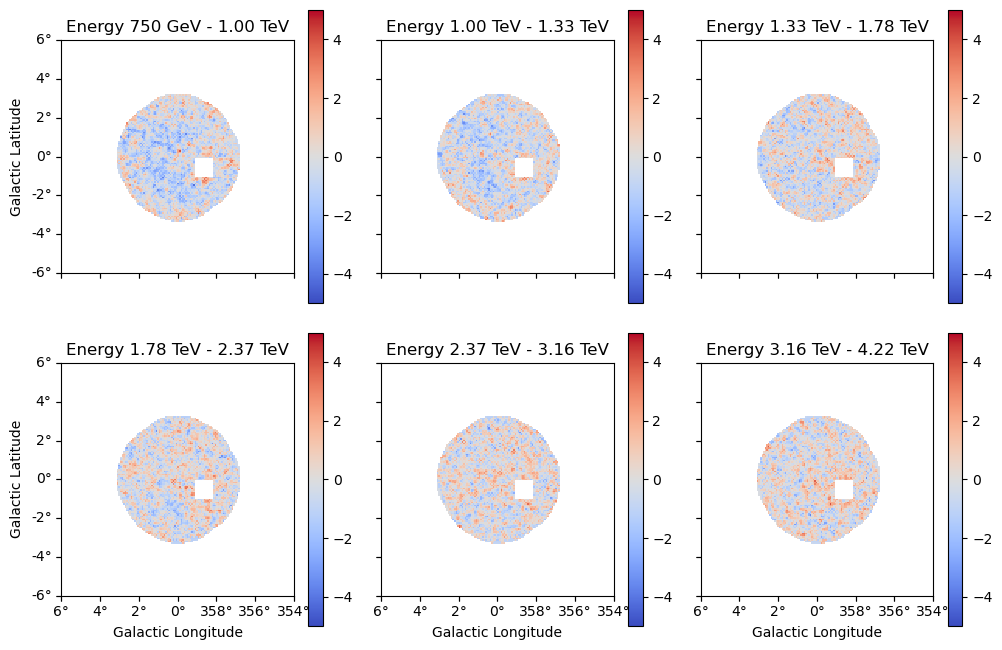

In [27]:
estimator_N = ExcessMapEstimator(
    correlation_radius=f"0.1 deg",
    energy_edges=dataset_standard_N.counts.geom.axes['energy'].edges[7:14])
result_N = estimator_N.run(dataset_standard_N)
result_N["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5,);

In [28]:
model2 = Models(dataset_standard.models).copy()
#model2.remove('diff')

model2_N = Models(dataset_standard_N.models).copy()
#model2_N.remove('diff')
#model2_N.remove(model2_N[-1])

In [29]:
print(model2)
print(model2_N)

Models

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.030   +/-    0.04             
    amplitude                     :   2.73e-12   +/- 8.3e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.089   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    359.943   +/-    0.00 deg         
    lat_0                         :     -0.049   +/-    0.00 deg         

Component 1: SkyModel

  Name                      : g09
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:


In [30]:
#diff = Map.read(f'{path}/diffusetemplate.fits')
#new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
#diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
#temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
#diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
model2['diff'].spatial_model.map.geom.rename_axes(['energy_true'], ['energy'])
model2_N['diff'].spatial_model.map.geom.rename_axes(['energy_true'], ['energy'])

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (64, 64, 300)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, -0.0 deg
	width      : 4.3 deg x 4.3 deg
	wcs ref    : 0.0 deg, 0.0 deg

In [31]:
model2.write("data/1_model_standard_best_fit_mask_full.yml", overwrite= True, full_output = True)

Template file already exits, and overwrite is False


In [32]:
model2_N.write("data/1_model_standard_nuisance_fit_mask_full.yml", overwrite= True, full_output = True)

Template file already exits, and overwrite is False


In [33]:
model2.remove('diff')
model2_N.remove('diff')
model2_N.remove(model2_N[-1])
model2.write("data/1_model_standard_best_fit_mask.yml", overwrite= True, full_output = True)
model2_N.write("data/1_model_standard_nuisance_fit_mask.yml", overwrite= True, full_output = True)

## Spectrum using Errors from Likelihood Scan (5b)

In [34]:
standard_error_array = []
standard_error_N_array = []
#Norm, Amplitude, Index, Lambda
val = dataset_standard.background_model.parameters['norm'].value
er = dataset_standard.background_model.parameters['norm'].error
standard_error_array.append([val, er])
val = dataset_standard.models[0].parameters['amplitude'].value
er = dataset_standard.models[0].parameters['amplitude'].error
standard_error_array.append([val, er])
val = dataset_standard.models[0].parameters['index'].value
er = dataset_standard.models[0].parameters['index'].error
standard_error_array.append([val, er])
val = dataset_standard.models[0].parameters['lambda_'].value
er = dataset_standard.models[0].parameters['lambda_'].error
standard_error_array.append([val, er])
print(standard_error_array)

val = dataset_standard_N.background_model.parameters['norm'].value
er = dataset_standard_N.background_model.parameters['norm'].error
standard_error_N_array.append([val, er])
val = dataset_standard_N.models[0].parameters['amplitude'].value
er = dataset_standard_N.models[0].parameters['amplitude'].error
standard_error_N_array.append([val, er])
val = dataset_standard_N.models[0].parameters['index'].value
er = dataset_standard_N.models[0].parameters['index'].error
standard_error_N_array.append([val, er])
val = dataset_standard_N.models[0].parameters['lambda_'].value
er = dataset_standard_N.models[0].parameters['lambda_'].error
standard_error_N_array.append([val, er])
print(standard_error_N_array)

[[1.0571040747392333, 0.0016241935677204344], [2.733011434009236e-12, 8.262906868322266e-14], [2.030101390516945, 0.039401465836845215], [0.08874510187310557, 0.013347642968012784]]
[[1.0571048819427318, 0.0016165659303589454], [2.7351285488707767e-12, 5.064065151626613e-13], [2.030245065296281, 0.04098248049555129], [0.0888134983549071, 0.01307448361648773]]


In [35]:
#Norm, Amplitude, Index, Lambda
asymmetric_error_array = []
asymmetric_error_N_array = []

import upper_limit_18_02
#import and set errors from 5b_stat_scan_zero_shift_tilt (fit produces weird errors)
#Background Norm
with open(f'data/5b_scan_norm_N.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
asymmetric_error_N_array.append([min_, [[er_neg], [er_pos]]])


with open(f'data/5b_scan_norm.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
asymmetric_error_array.append([min_, [[er_neg], [er_pos]]])


#Amplitude
with open(f'data/5b_scan_amplitude_N.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
asymmetric_error_N_array.append([min_, [[er_neg], [er_pos]]])

with open(f'data/5b_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
asymmetric_error_array.append([min_, [[er_neg], [er_pos]]])


#Index
with open(f'data/5b_scan_index_N.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
asymmetric_error_N_array.append([min_, [[er_neg], [er_pos]]])

with open(f'data/5b_scan_index.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
asymmetric_error_array.append([min_, [[er_neg], [er_pos]]])


#Lambda
with open(f'data/5b_scan_lambda_N.yaml') as file:
            stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
if er_neg < 0:
    er_neg = min_
asymmetric_error_N_array.append([min_, [[er_neg], [er_pos]]])

with open(f'data/5b_scan_lambda.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0];
if er_neg < 0:
    er_neg = min_
asymmetric_error_array.append([min_, [[er_neg], [er_pos]]])

print(asymmetric_error_array)
print(asymmetric_error_N_array)
print(asymmetric_error_N_array[2][1][1][0])

[[1.0573136655730806, [[0.0018262023042192599], [0.001530500507628485]]], [2.7317715846958843e-12, [[8.778133138537733e-14], [8.81119578689381e-14]]], [2.0310079264098237, [[0.04548445306007287], [0.044302014938926604]]], [0.08842614204734911, [[0.014704901633877956], [0.01601200400133379]]]]
[[1.057106499047697, [[0.0016268075951393346], [0.0016268075951395566]]], [2.7319202381711768e-12, [[2.6206832661969007e-13], [3.174539008022023e-13]]], [2.0307780151926886, [[0.04788349838493211], [0.04681759859211709]]], [0.0885461820606869, [[0.015735245081693897], [0.015995331777259092]]]]
0.04681759859211709


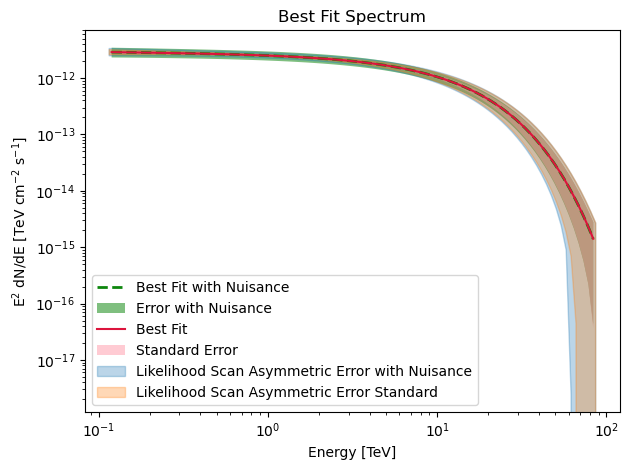

In [36]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value

fig,ax = plt.subplots()#figsize=(10,5))

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

energy_fine = np.logspace(np.log10(energy_bounds[0].value),
                         np.log10(energy_bounds[-1].value),
                         100)
par_names = ['amplitude', 'index', 'lambda_']

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
for i, p in enumerate(par_names):
    dataset_standard.models[0].parameters[p].value = standard_error_array[i+1][0]
    dataset_standard.models[0].parameters[p].error = standard_error_array[i+1][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
for i, p in enumerate(par_names):
    dataset_standard_N.models[0].parameters[p].value = standard_error_N_array[i+1][0]
    dataset_standard_N.models[0].parameters[p].error = standard_error_N_array[i+1][1]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.7,
                                                          label= "Standard Error"
                                                         )

#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
for i, p in enumerate(par_names):
    dataset_standard.models[0].parameters[p].value = asymmetric_error_array[i+1][0]
    dataset_standard.models[0].parameters[p].error = asymmetric_error_array[i+1][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
for i, p in enumerate(par_names):
    dataset_standard_N.models[0].parameters[p].value = asymmetric_error_N_array[i+1][0]
    dataset_standard_N.models[0].parameters[p].error = asymmetric_error_N_array[i+1][1][1][0]

pos = dataset_standard.models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
pos = (pos[0] + pos[1]).value
pos_N = dataset_standard_N.models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
pos_N = (pos_N[0] + pos_N[1]).value

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
for i, p in enumerate(par_names):
    dataset_standard.models[0].parameters[p].value = asymmetric_error_array[i+1][0]
    dataset_standard.models[0].parameters[p].error = asymmetric_error_array[i+1][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
for i, p in enumerate(par_names):
    dataset_standard_N.models[0].parameters[p].value = asymmetric_error_N_array[i+1][0]
    dataset_standard_N.models[0].parameters[p].error = asymmetric_error_N_array[i+1][1][0][0]

neg = dataset_standard.models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
neg = (neg[0] - neg[1]).value
neg_N = dataset_standard_N.models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
neg_N = (neg_N[0] - neg_N[1]).value

ax.fill_between(energy_fine, neg_N, pos_N, alpha = 0.3, color = 'tab:blue', label = 'Likelihood Scan Asymmetric Error with Nuisance')
ax.fill_between(energy_fine, neg, pos, alpha = 0.3, color = 'tab:orange', label = 'Likelihood Scan Asymmetric Error Standard')


#ax.set_ylim([1e-12,4e-12]); ax.set_xlim([0.1, 4])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectrum_asym_error_full.pdf")

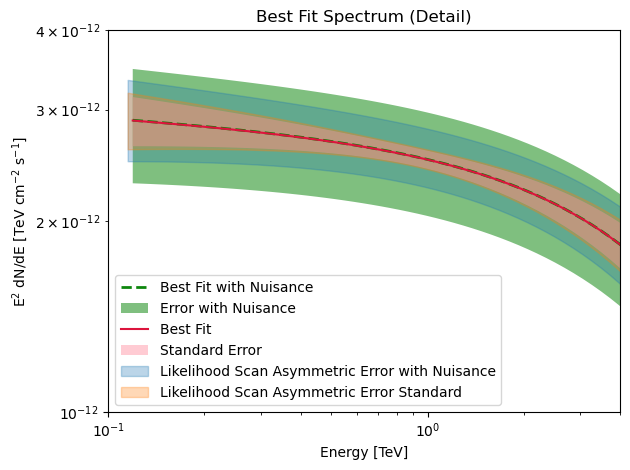

In [37]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value

fig,ax = plt.subplots()#figsize=(10,5))

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

energy_fine = np.logspace(np.log10(energy_bounds[0].value),
                         np.log10(energy_bounds[-1].value),
                         100)
par_names = ['amplitude', 'index', 'lambda_']

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
for i, p in enumerate(par_names):
    dataset_standard.models[0].parameters[p].value = standard_error_array[i+1][0]
    dataset_standard.models[0].parameters[p].error = standard_error_array[i+1][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
for i, p in enumerate(par_names):
    dataset_standard_N.models[0].parameters[p].value = standard_error_N_array[i+1][0]
    dataset_standard_N.models[0].parameters[p].error = standard_error_N_array[i+1][1]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.7,
                                                          label= "Standard Error"
                                                         )

#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
for i, p in enumerate(par_names):
    dataset_standard.models[0].parameters[p].value = asymmetric_error_array[i+1][0]
    dataset_standard.models[0].parameters[p].error = asymmetric_error_array[i+1][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
for i, p in enumerate(par_names):
    dataset_standard_N.models[0].parameters[p].value = asymmetric_error_N_array[i+1][0]
    dataset_standard_N.models[0].parameters[p].error = asymmetric_error_N_array[i+1][1][1][0]

pos = dataset_standard.models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
pos = (pos[0] + pos[1]).value
pos_N = dataset_standard_N.models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
pos_N = (pos_N[0] + pos_N[1]).value

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
for i, p in enumerate(par_names):
    dataset_standard.models[0].parameters[p].value = asymmetric_error_array[i+1][0]
    dataset_standard.models[0].parameters[p].error = asymmetric_error_array[i+1][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
for i, p in enumerate(par_names):
    dataset_standard_N.models[0].parameters[p].value = asymmetric_error_N_array[i+1][0]
    dataset_standard_N.models[0].parameters[p].error = asymmetric_error_N_array[i+1][1][0][0]

neg = dataset_standard.models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
neg = (neg[0] - neg[1]).value
neg_N = dataset_standard_N.models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
neg_N = (neg_N[0] - neg_N[1]).value

ax.fill_between(energy_fine, neg_N, pos_N, alpha = 0.3, color = 'tab:blue', label = 'Likelihood Scan Asymmetric Error with Nuisance')
ax.fill_between(energy_fine, neg, pos, alpha = 0.3, color = 'tab:orange', label = 'Likelihood Scan Asymmetric Error Standard')


ax.set_ylim([1e-12,4e-12]); ax.set_xlim([0.1, 4])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum (Detail)")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectrum_asym_error_zoom.pdf")

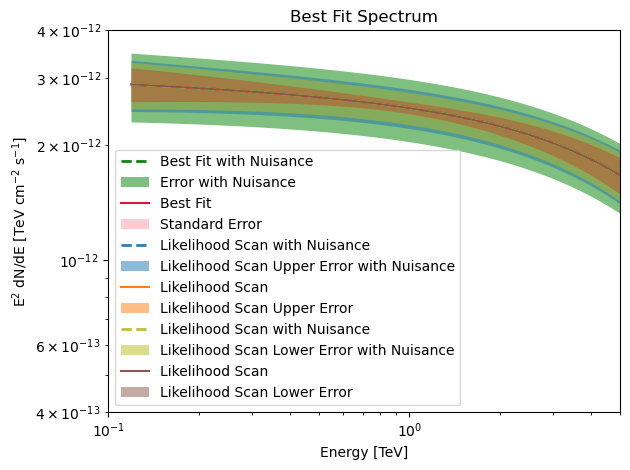

In [38]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()#figsize = (9,4))

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
dataset_standard.models[0].parameters['amplitude'].value = standard_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = standard_error_array[1][1]
dataset_standard.models[0].parameters['index'].value = standard_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = standard_error_array[2][1]
dataset_standard.models[0].parameters['lambda_'].value = standard_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = standard_error_array[3][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
dataset_standard_N.models[0].parameters['amplitude'].value = standard_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = standard_error_N_array[1][1]
dataset_standard_N.models[0].parameters['index'].value = standard_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = standard_error_N_array[2][1]
dataset_standard_N.models[0].parameters['lambda_'].value = standard_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = standard_error_N_array[3][1]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.7,
                                                          label= "Standard Error"
                                                         )

#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][1][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][1][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][1][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][1][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][1][0]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='tab:blue',
                                                         label="Likelihood Scan with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:blue',
                                                         label="Likelihood Scan Upper Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Likelihood Scan", color = "tab:orange")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:orange',
                                                          alpha = 0.5,
                                                          label= "Likelihood Scan Upper Error"
                                                         )

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][0][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][0][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][0][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][0][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][0][0]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='tab:olive',
                                                         label="Likelihood Scan with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:olive',
                                                         label="Likelihood Scan Lower Error with Nuisance",
                                                        alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Likelihood Scan", color = "tab:brown")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:brown',
                                                          alpha = 0.5,
                                                          label= "Likelihood Scan Lower Error"
                                                         )



ax.set_ylim([0.4e-12,4e-12]); ax.set_xlim([0.1, 5])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectra_asym_error_full_zoom.pdf")

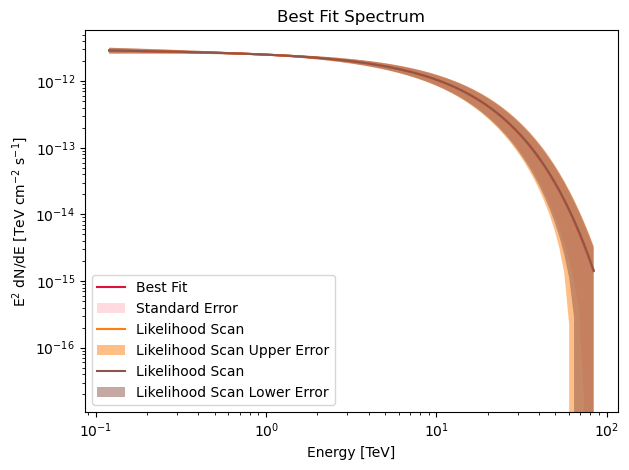

In [39]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
dataset_standard.models[0].parameters['amplitude'].value = standard_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = standard_error_array[1][1]
dataset_standard.models[0].parameters['index'].value = standard_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = standard_error_array[2][1]
dataset_standard.models[0].parameters['lambda_'].value = standard_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = standard_error_array[3][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
dataset_standard_N.models[0].parameters['amplitude'].value = standard_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = standard_error_N_array[1][1]
dataset_standard_N.models[0].parameters['index'].value = standard_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = standard_error_N_array[2][1]
dataset_standard_N.models[0].parameters['lambda_'].value = standard_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = standard_error_N_array[3][1]

# dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                                        color='green',
#                                                          label="Best Fit with Nuisance",
#                                                         alpha = 0.95,
#                                                        linestyle='dashed', linewidth= 2)        
# dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='green',
#                                                          label="Error with Nuisance",
#                                                         alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.5,
                                                          label= "Standard Error"
                                                         )


#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][1][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][1][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][1][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][1][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][1][0]

# dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                                        color='tab:blue',
#                                                          label="Likelihood Scan with Nuisance",
#                                                         alpha = 0.95,
#                                                        linestyle='dashed', linewidth= 2)        
# dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:blue',
#                                                          label="Likelihood Scan Upper Error with Nuisance",
#                                                         alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Likelihood Scan", color = "tab:orange")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:orange',
                                                          alpha = 0.5,
                                                          label= "Likelihood Scan Upper Error"
                                                         )

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][0][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][0][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][0][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][0][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][0][0]

# dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                                        color='tab:olive',
#                                                          label="Likelihood Scan with Nuisance",
#                                                         alpha = 0.95,
#                                                        linestyle='dashed', linewidth= 2)        
# dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:olive',
#                                                          label="Likelihood Scan Lower Error with Nuisance",
#                                                         alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Likelihood Scan", color = "tab:brown")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:brown',
                                                          alpha = 0.5,
                                                          label= "Likelihood Scan Lower Error"
                                                         )


#ax.set_ylim([1e-12,4e-12]); ax.set_xlim([0.1, 5])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectra_asym_error_standard.pdf")

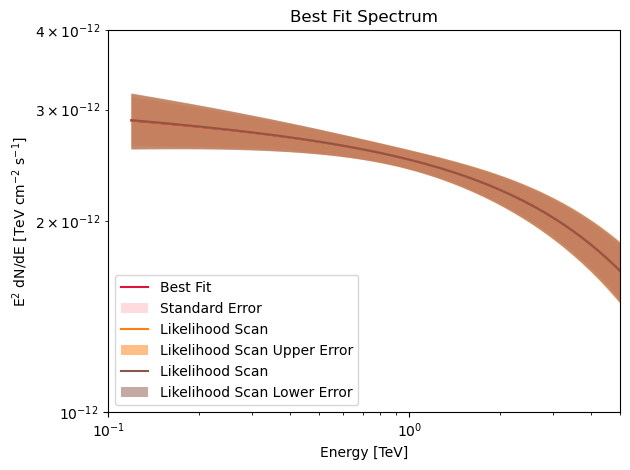

In [40]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
dataset_standard.models[0].parameters['amplitude'].value = standard_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = standard_error_array[1][1]
dataset_standard.models[0].parameters['index'].value = standard_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = standard_error_array[2][1]
dataset_standard.models[0].parameters['lambda_'].value = standard_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = standard_error_array[3][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
dataset_standard_N.models[0].parameters['amplitude'].value = standard_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = standard_error_N_array[1][1]
dataset_standard_N.models[0].parameters['index'].value = standard_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = standard_error_N_array[2][1]
dataset_standard_N.models[0].parameters['lambda_'].value = standard_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = standard_error_N_array[3][1]

# dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                                        color='green',
#                                                          label="Best Fit with Nuisance",
#                                                         alpha = 0.95,
#                                                        linestyle='dashed', linewidth= 2)        
# dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='green',
#                                                          label="Error with Nuisance",
#                                                         alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Best Fit", color = "crimson")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='lightpink',
                                                          alpha = 0.5,
                                                          label= "Standard Error"
                                                         )


#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][1][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][1][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][1][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][1][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][1][0]

# dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                                        color='tab:blue',
#                                                          label="Likelihood Scan with Nuisance",
#                                                         alpha = 0.95,
#                                                        linestyle='dashed', linewidth= 2)        
# dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:blue',
#                                                          label="Likelihood Scan Upper Error with Nuisance",
#                                                         alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Likelihood Scan", color = "tab:orange")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:orange',
                                                          alpha = 0.5,
                                                          label= "Likelihood Scan Upper Error"
                                                         )

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][0][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][0][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][0][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][0][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][0][0]

# dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                                        color='tab:olive',
#                                                          label="Likelihood Scan with Nuisance",
#                                                         alpha = 0.95,
#                                                        linestyle='dashed', linewidth= 2)        
# dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:olive',
#                                                          label="Likelihood Scan Lower Error with Nuisance",
#                                                         alpha = 0.5)
dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "Likelihood Scan", color = "tab:brown")
dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:brown',
                                                          alpha = 0.5,
                                                          label= "Likelihood Scan Lower Error"
                                                         )


ax.set_ylim([1e-12,4e-12]); ax.set_xlim([0.1, 5])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectra_asym_error_standard_zoom.pdf")

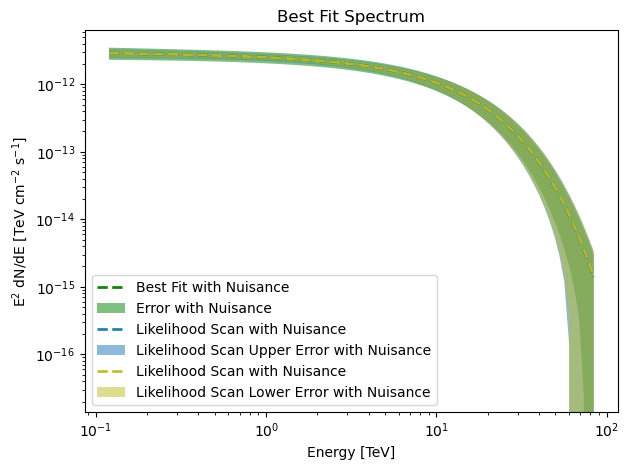

In [41]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
dataset_standard.models[0].parameters['amplitude'].value = standard_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = standard_error_array[1][1]
dataset_standard.models[0].parameters['index'].value = standard_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = standard_error_array[2][1]
dataset_standard.models[0].parameters['lambda_'].value = standard_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = standard_error_array[3][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
dataset_standard_N.models[0].parameters['amplitude'].value = standard_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = standard_error_N_array[1][1]
dataset_standard_N.models[0].parameters['index'].value = standard_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = standard_error_N_array[2][1]
dataset_standard_N.models[0].parameters['lambda_'].value = standard_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = standard_error_N_array[3][1]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
# dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                 label = "Best Fit", color = "crimson")
# dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='lightpink',
#                                                           alpha = 0.3,
#                                                           label= "Standard Error"
#                                                          )


#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][1][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][1][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][1][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][1][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][1][0]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='tab:blue',
                                                         label="Likelihood Scan with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:blue',
                                                         label="Likelihood Scan Upper Error with Nuisance",
                                                        alpha = 0.5)
# dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                 label = "Likelihood Scan", color = "tab:orange")
# dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:orange',
#                                                           alpha = 0.5,
#                                                           label= "Likelihood Scan Upper Error"
#                                                          )

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][0][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][0][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][0][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][0][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][0][0]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='tab:olive',
                                                         label="Likelihood Scan with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:olive',
                                                         label="Likelihood Scan Lower Error with Nuisance",
                                                        alpha = 0.5)
# dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                 label = "Likelihood Scan", color = "tab:brown")
# dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:brown',
#                                                           alpha = 0.5,
#                                                           label= "Likelihood Scan Lower Error"
#                                                          )


#ax.set_ylim([1e-12,4e-12]); ax.set_xlim([0.1, 5])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectra_asym_error_nuisance.pdf")

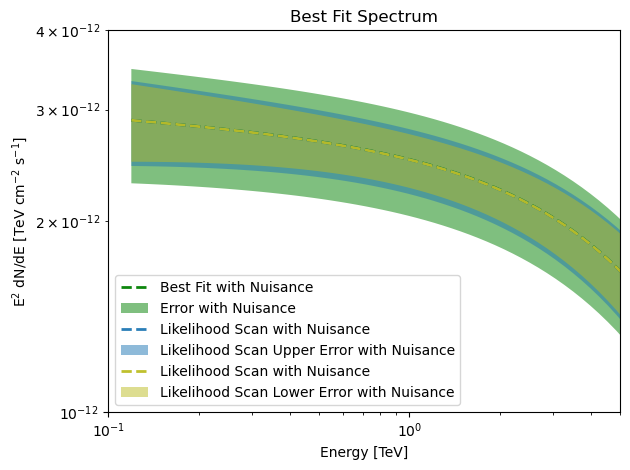

In [42]:
true_energy = dataset_standard_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

#Values and Errrors from Fit
dataset_standard.background_model.parameters['norm'].value = standard_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = standard_error_array[0][1]
dataset_standard.models[0].parameters['amplitude'].value = standard_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = standard_error_array[1][1]
dataset_standard.models[0].parameters['index'].value = standard_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = standard_error_array[2][1]
dataset_standard.models[0].parameters['lambda_'].value = standard_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = standard_error_array[3][1]

dataset_standard_N.background_model.parameters['norm'].value = standard_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = standard_error_N_array[0][1]
dataset_standard_N.models[0].parameters['amplitude'].value = standard_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = standard_error_N_array[1][1]
dataset_standard_N.models[0].parameters['index'].value = standard_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = standard_error_N_array[2][1]
dataset_standard_N.models[0].parameters['lambda_'].value = standard_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = standard_error_N_array[3][1]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
# dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                 label = "Best Fit", color = "crimson")
# dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='lightpink',
#                                                           alpha = 0.3,
#                                                           label= "Standard Error"
#                                                          )


#Likelihood Scan Upper Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][1][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][1][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][1][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][1][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][1][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][1][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][1][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][1][0]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='tab:blue',
                                                         label="Likelihood Scan with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:blue',
                                                         label="Likelihood Scan Upper Error with Nuisance",
                                                        alpha = 0.5)
# dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                 label = "Likelihood Scan", color = "tab:orange")
# dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:orange',
#                                                           alpha = 0.5,
#                                                           label= "Likelihood Scan Upper Error"
#                                                          )

#Likelihood Scan Lower Error
dataset_standard.background_model.parameters['norm'].value = asymmetric_error_array[0][0]
dataset_standard.background_model.parameters['norm'].error = asymmetric_error_array[0][1][0][0]
dataset_standard.models[0].parameters['amplitude'].value = asymmetric_error_array[1][0]
dataset_standard.models[0].parameters['amplitude'].error = asymmetric_error_array[1][1][0][0]
dataset_standard.models[0].parameters['index'].value = asymmetric_error_array[2][0]
dataset_standard.models[0].parameters['index'].error = asymmetric_error_array[2][1][0][0]
dataset_standard.models[0].parameters['lambda_'].value = asymmetric_error_array[3][0]
dataset_standard.models[0].parameters['lambda_'].error = asymmetric_error_array[3][1][0][0]

dataset_standard_N.background_model.parameters['norm'].value = asymmetric_error_N_array[0][0]
dataset_standard_N.background_model.parameters['norm'].error = asymmetric_error_N_array[0][1][0][0]
dataset_standard_N.models[0].parameters['amplitude'].value = asymmetric_error_N_array[1][0]
dataset_standard_N.models[0].parameters['amplitude'].error = asymmetric_error_N_array[1][1][0][0]
dataset_standard_N.models[0].parameters['index'].value = asymmetric_error_N_array[2][0]
dataset_standard_N.models[0].parameters['index'].error = asymmetric_error_N_array[2][1][0][0]
dataset_standard_N.models[0].parameters['lambda_'].value = asymmetric_error_N_array[3][0]
dataset_standard_N.models[0].parameters['lambda_'].error = asymmetric_error_N_array[3][1][0][0]

dataset_standard_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                                       color='tab:olive',
                                                         label="Likelihood Scan with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_standard_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='tab:olive',
                                                         label="Likelihood Scan Lower Error with Nuisance",
                                                        alpha = 0.5)
# dataset_standard.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                 label = "Likelihood Scan", color = "tab:brown")
# dataset_standard.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                        facecolor='tab:brown',
#                                                           alpha = 0.5,
#                                                           label= "Likelihood Scan Lower Error"
#                                                          )


ax.set_ylim([1e-12,4e-12]); ax.set_xlim([0.1, 5])
plt.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
plt.title("Best Fit Spectrum")
plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectra_asym_error_nuisance_zoom.pdf")

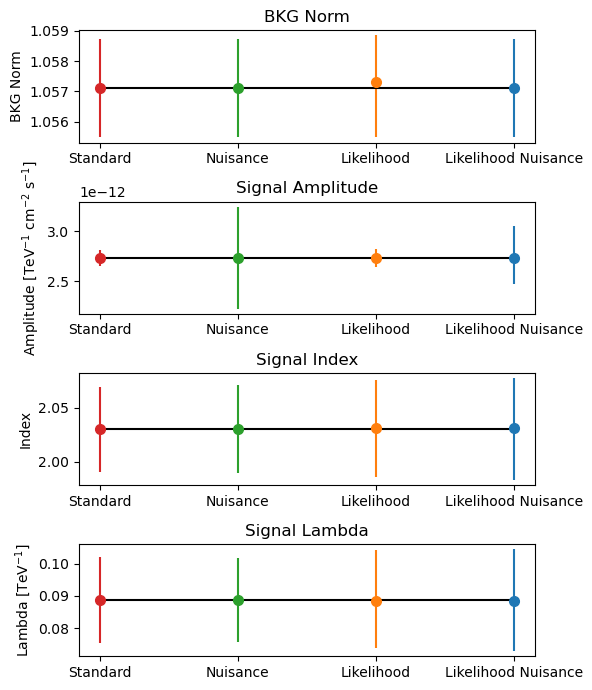

In [83]:
fig, axs = plt.subplots(4,1, figsize= (6, 7))

axs[0].set_title('BKG Norm')
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")

par_names = ['norm', 'amplitude', 'index', 'lambda_']

array_array = [standard_error_array, standard_error_N_array, asymmetric_error_array, asymmetric_error_N_array]

labels = ['Best Fit', 'Best Fit with Nuisance', 'Likelihood Scan Asymmetric Error', 
              'Likelihood Scan Asymmetric Error with Nuisance']
labels_short = ['Standard', 'Nuisance', 'Likelihood', 'Likelihood Nuisance']

color_array = ['tab:red', 'tab:green', 'tab:orange', 'tab:blue']

for j, a in enumerate(array_array):
    for i, p in enumerate(par_names):
        axs[i].errorbar(x = 1 + j, y = a[i][0], yerr = a[i][1], 
                        color = color_array[j], fmt = 'o', markersize = 7, label = labels[j])

for i, p in enumerate(par_names):
        axs[i].hlines(y = array_array[0][i][0], xmin = 1, xmax = 4,
                        color = 'black', label = 'Input (Best Fit)')
plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
#     ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
#             loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.set_ylabel(''); 
#     ax.set_xlabel(''); 
    ax.set_xticks(np.arange(len(array_array))+1, labels_short)

axs[0].set_ylabel('BKG Norm')
axs[1].set_ylabel('Amplitude [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
axs[2].set_ylabel('Index')
axs[3].set_ylabel('Lambda [TeV$^{-1}$]')
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/1b_best_fit_parameters_comparison_methods.pdf")   
